In [1]:
# import package
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Input, Dense, Dropout,
                                     Activation, Flatten, Conv2D,
                                     MaxPooling2D)

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


In [5]:
x_test.shape

(10000, 32, 32, 3)

In [6]:
# 記得轉成 'float32'
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# 將 features (照片影像特徵值) 標準化，可以提高模型預測的準確度，並且更快收斂
x_train /= 255  # rescaling
x_test /= 255   # rescaling

x_train.shape

(50000, 32, 32, 3)

In [7]:
# 將訓練資料與測試資料的 label，進行 Onehot encoding 轉換
num_classes = 10
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

y_train = np.eye(num_classes, dtype='float32')[y_train[:, 0]]
y_test = np.eye(num_classes, dtype='float32')[y_test[:, 0]]

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (50000, 10)
y_test shape: (10000, 10)


In [8]:
premodel = tf.keras.applications.VGG16(weights='imagenet', include_top=False,input_shape=x_train.shape[1:])
premodel.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

In [16]:
from keras.regularizers import l2,l1
for layer in premodel.layers[-4:]:
    layer.trainable = True
for layer in premodel.layers[:-4]:
    layer.trainable = False
dr=0.25
l2_r=0.006
l1_r=0.006
flt=tf.keras.layers.Flatten()(premodel.output)
D1=tf.keras.layers.Dense(512, activation="relu",kernel_regularizer=l1(l1_r))(flt)
D1=tf.keras.layers.Dropout(rate=dr)(D1)
D2=tf.keras.layers.Dense(64, activation="relu",kernel_regularizer=l1(l1_r))(D1)
D2=tf.keras.layers.Dropout(rate=dr)(D2)
OP2=tf.keras.layers.Dense(10, activation="softmax")(D2)
model = tf.keras.Model(premodel.input, OP2)

In [17]:
# 編譯模型
# 選用 Adam 為 optimizer
learning_rate = 0.0003
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy'])

In [18]:
model_dir = 'model-logs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model', model.__class__.__name__)
model_cbk = tf.keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = tf.keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,
                                          verbose=1)


callbacks_list = [model_cbk, model_mckp, earlystop]

In [19]:
batch_size = 128
epochs = 200
rn50_history = model.fit(x_train, y_train,
  batch_size=batch_size,
  epochs=epochs,
  validation_data=(x_test, y_test),
  verbose=1,
  shuffle=True,
  callbacks=callbacks_list)

Epoch 1/200
391/391 [==============================] - 37s 95ms/step - loss: 27.2300 - accuracy: 0.7421 - val_loss: 10.7325 - val_accuracy: 0.7705
Epoch 2/200
391/391 [==============================] - 37s 94ms/step - loss: 7.7918 - accuracy: 0.7807 - val_loss: 5.5562 - val_accuracy: 0.7745
Epoch 3/200
391/391 [==============================] - 36s 92ms/step - loss: 4.1288 - accuracy: 0.7824 - val_loss: 3.0424 - val_accuracy: 0.7695
Epoch 4/200
391/391 [==============================] - 36s 93ms/step - loss: 2.3309 - accuracy: 0.7843 - val_loss: 1.8256 - val_accuracy: 0.7770
Epoch 5/200
391/391 [==============================] - 36s 92ms/step - loss: 1.4804 - accuracy: 0.7885 - val_loss: 1.2665 - val_accuracy: 0.7766
Epoch 6/200
391/391 [==============================] - 36s 93ms/step - loss: 1.0918 - accuracy: 0.7906 - val_loss: 1.0060 - val_accuracy: 0.7753
Epoch 7/200
391/391 [==============================] - 36s 92ms/step - loss: 0.9136 - accuracy: 0.7919 - val_loss: 0.9219 - val_

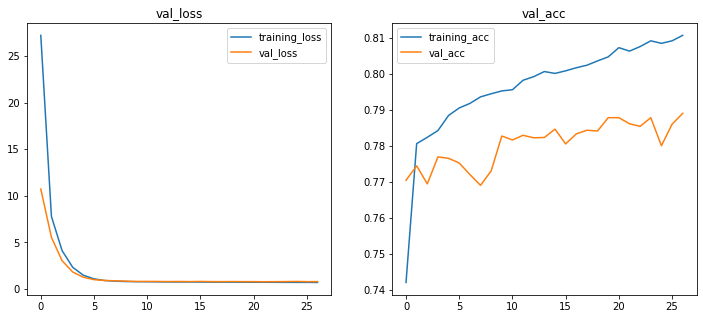

In [20]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(rn50_history.history[eachx])
    plt.plot(np.arange(l_x), rn50_history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title(eachy)
plt.show()

In [21]:
conv_layers=[]
for layer in model.layers:
    if ("conv" in layer.name):
        print(layer.name)
        print(layer.get_weights()[0].shape)
        conv_layers=conv_layers+[layer.name] 

block1_conv1
(3, 3, 3, 64)
block1_conv2
(3, 3, 64, 64)
block2_conv1
(3, 3, 64, 128)
block2_conv2
(3, 3, 128, 128)
block3_conv1
(3, 3, 128, 256)
block3_conv2
(3, 3, 256, 256)
block3_conv3
(3, 3, 256, 256)
block4_conv1
(3, 3, 256, 512)
block4_conv2
(3, 3, 512, 512)
block4_conv3
(3, 3, 512, 512)
block5_conv1
(3, 3, 512, 512)
block5_conv2
(3, 3, 512, 512)
block5_conv3
(3, 3, 512, 512)


In [78]:
model.get_layer(conv_layers[0]).get_weights()[0].shape

(3, 3, 3, 64)

In [222]:
## Capture the possible effect of each layer, max pool not included
# Usage: 
# job=filt_to_image(model) # establish class and list convolution layers
# job.get_equ_fil(n) #calculate get_equ_filter for each possible layers (~layer n)
# job.plot_eqfil(n,n_samples) # plot the effect of equivalent of n th layer 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
class filt_to_image():
  
  def __init__(self,model):

    self.model=model
    self.conv_layers=[layer.name for layer in self.model.layers if ("conv" in layer.name)]
    self.nlayers=len(self.conv_layers)
    self.equ_fil=[0]*self.nlayers
    self.get_equ_fil(job.nlayers-1);
  def get_equ_fil(self,rng,pad_acc=0):
    fil=self.model.get_layer(self.conv_layers[rng]).get_weights()[0]
    PAD=(fil.shape[0]-1)//2
    if rng==0:    
      img=tf.random.normal([1,fil.shape[0]+2*pad_acc,fil.shape[1]+2*pad_acc,fil.shape[2]])
    else:
      img=self.get_equ_fil(rng-1,pad_acc+PAD)
    self.equ_fil[rng]=tf.nn.conv2d(img, fil, strides= [1, 1, 1, 1], padding="SAME")
    return self.equ_fil[rng]
  def plot_eqfil(self,rng=0,n_samples=25):

    x_a=np.ceil(np.sqrt(n_samples))
    y_a=np.floor(np.sqrt(n_samples))
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(hspace=0.02,wspace=0.01,
                    left=0,right=1,bottom=0, top=1)
    ## original picture
    total_samples=self.equ_fil[rng].shape[3]
    order=np.linspace(1,total_samples,total_samples,dtype="int")
    random.shuffle(order)
    i = 1
    for sample in order[0:n_samples]:
        ax = fig.add_subplot(x_a, y_a, i,xticks=[],yticks=[]) 
        ax.imshow(np.squeeze(self.equ_fil[rng][:,:,:,sample]))
        ax.set_title(f"sample{sample}")
        i += 1
    plt.show()

In [223]:
job=filt_to_image(model)

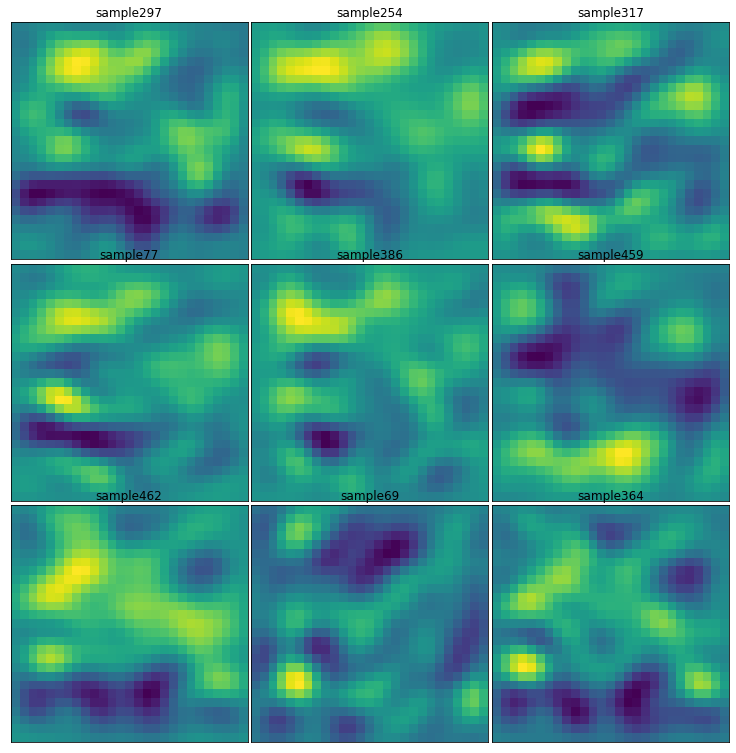

In [228]:
job.plot_eqfil(12,9)